In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm, truncnorm
import corner
import arviz as az
import seaborn as sns
import pymc as pm
import emcee
from scipy.stats import gaussian_kde
import numpyro
from jax import random
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro import sample, plate
from numpyro.infer import MCMC, NUTS


In [170]:
df = pd.read_csv('../data/gaiadr3_solar_neighborhood.csv')
df

,mg,bp_rp,parallax
0,10.390250,2.731872,10.000008
1,8.608481,2.025819,10.000029
2,4.267759,0.880858,10.000032
3,10.506658,2.649735,10.000066
4,12.077941,2.940875,10.000111
...,...,...,...
227624,11.758283,2.834036,336.026602
227625,9.521769,2.215609,392.752945
227626,14.129570,4.184836,415.179416
227627,11.883816,2.833697,546.975940


In [171]:
nearby_sel = df.parallax > 40.
nearby_df = df[nearby_sel]

In [172]:
afterExclude_df = nearby_df[(nearby_df['mg'] > 10) & (nearby_df['bp_rp'] > 1)]  
print(afterExclude_df)

               mg     bp_rp    parallax
223559  11.544313  2.992254   40.002314
223560  13.563787  3.794676   40.004848
223561  10.197586  2.492932   40.007115
223562  12.769197  3.373776   40.014745
223563  12.413716  3.135756   40.019696
...           ...       ...         ...
227623  12.881017  3.529414  316.481187
227624  11.758283  2.834036  336.026602
227626  14.129570  4.184836  415.179416
227627  11.883816  2.833697  546.975940
227628  13.411743  3.804580  768.066539

[2214 rows x 3 columns]


In [173]:
# Function to build the linear model
def build_model(m, b):
    def model(x):
        return m * x + b
    return model

# Defining linear model with priors
def linear_model(x=None, y=None):
    # Priors for slope (m) and intercept (b)
    m = numpyro.sample('m', dist.Uniform(0, 5))
    b = numpyro.sample('b', dist.Uniform(0, 500))
    
    # Defining the prior for the scatter (sigma_MG)
    sigma_MG = numpyro.sample('sigma_MG', dist.HalfNormal(5.0))

    #model to calculate μ
    model = build_model(m, b)
    μ = model(x)

    # Likelihood: using normal distribution for the observations
    with numpyro.plate("data", len(x)):
        numpyro.sample("y", dist.Normal(μ, sigma_MG), obs=y)

# Log-likelihood function (for custom optimization or evaluation)
def lnlikelihood(m, b, sigma_MG, x, y):
    N = x.size
    model = build_model(m, b)
    lnlike = -.5 * N * (np.log(2 * np.pi * sigma_MG ** 2)) - (1 / (2 * sigma_MG ** 2)) * np.sum((y - model(x)) ** 2)
    return lnlike

# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Set up the MCMC kernel using NUTS
kernel = infer.NUTS(linear_model)

# Configure MCMC sampling
num_samples = 5000
num_warmup = 1000
num_chains = 2  

# Preparing data
x_data = afterExclude_df['bp_rp'].values
y_data = afterExclude_df['mg'].values

# Run MCMC
mcmc = infer.MCMC(kernel, num_chains=num_chains, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, x=x_data, y=y_data)

#summary 
mcmc.print_summary()


C:\Users\rabin\AppData\Local\Temp\ipykernel_16124\2151259325.py:48: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = infer.MCMC(kernel, num_chains=num_chains, num_warmup=num_warmup, num_samples=num_samples)
sample: 100%|██████████| 6000/6000 [00:03<00:00, 1797.82it/s, 1 steps of size 1.41e-01. acc. prob=0.94] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      8.21      0.12      8.21      8.01      8.40   2378.33      1.00
         m      1.21      0.04      1.21      1.14      1.27   2498.72      1.00
  sigma_MG      1.13      0.02      1.13      1.10      1.16   4268.66      1.00

Number of divergences: 0


In [174]:
samples = mcmc.get_samples()

In [175]:
samples['b'].shape

(10000,)

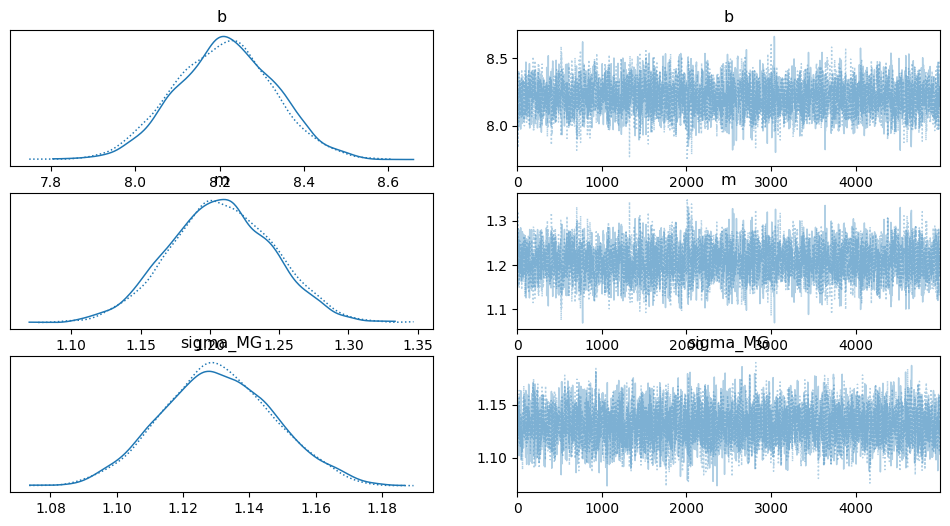

In [176]:
az.plot_trace(mcmc);

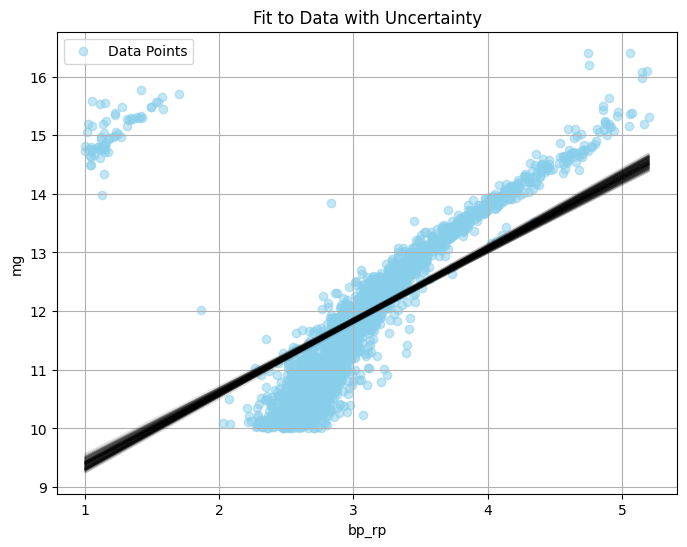

In [177]:
posterior_samples = mcmc.get_samples()

# Preparing data
x_data = afterExclude_df['bp_rp'].values
y_data = afterExclude_df['mg'].values

# Creating a function to plot the data and regression lines
def best_fit(x, y, samples):
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='skyblue', label='Data Points', alpha=0.5)

    #regression lines based on posterior samples
    for i in range(100):  
        m = samples['m'][i]
        b = samples['b'][i]
        plt.plot(x, m * x + b, color='black', alpha=0.1)  

    plt.xlabel('bp_rp')
    plt.ylabel('mg')
    plt.title('Fit to Data with Uncertainty')
    plt.legend()
    plt.grid()
    plt.show()

# Calling plotting function with the data and posterior samples
best_fit(x_data, y_data, posterior_samples)


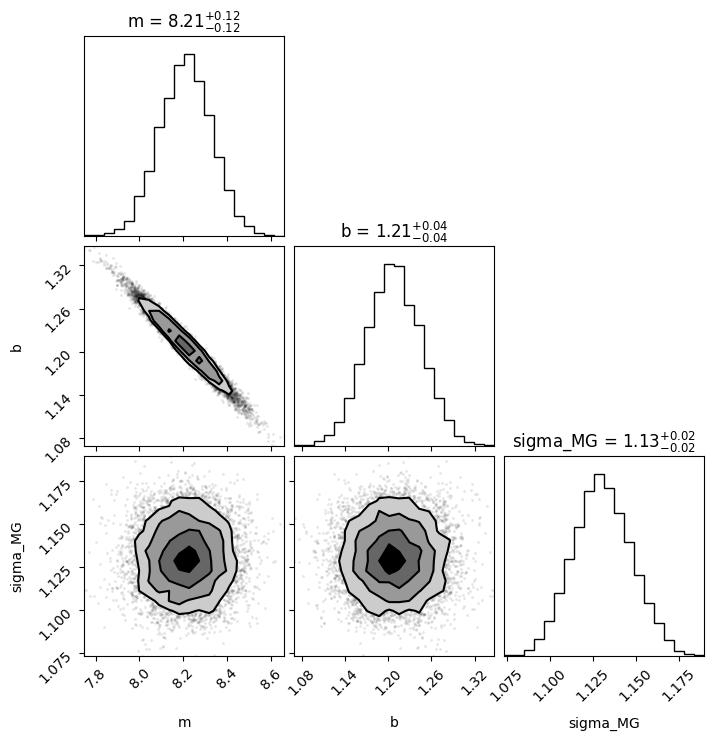

In [178]:
posterior_samples = mcmc.get_samples()

# Converting DataFrame for easier manipulation
samples_df = pd.DataFrame(posterior_samples)

# plotting 
fig = corner.corner(samples_df, 
                    labels=["m", "b", "sigma_MG"],  
                    show_titles=True, 
                    title_kwargs={"fontsize": 12},
                    hist_kwargs={'density': True},  
                    fill_contours=True)  

plt.show()


Q1: This result looks far better than the previous one. Previously it took more than 10 minutes to run single cell. 

Q2: We can see in plots sampling is more smooth and easy to manupulate plots. 

In [179]:
x_data = jnp.array(x_data)
y_data = jnp.array(y_data)

In [ ]:
# Function for posterior predictive sampling
def posterior_predictive(x):
    m_sample = np.random.choice(posterior_samples['m'])
    b_sample = np.random.choice(posterior_samples['b'])
    sigma_sample = np.random.choice(posterior_samples['sigma_MG'])
    
    μ = m_sample * x + b_sample
    y_new = np.random.normal(μ, sigma_sample)
    return y_new

# Simulating new data
def simulate_data(num_simulations, x_data):
    simulated_data = []
    for _ in range(num_simulations):
        y_sim = posterior_predictive(x_data)
        simulated_data.append(y_sim)
    return np.array(simulated_data)

num_simulations = 100

# Generate simulated data
simulated_data = simulate_data(num_simulations, x_data)


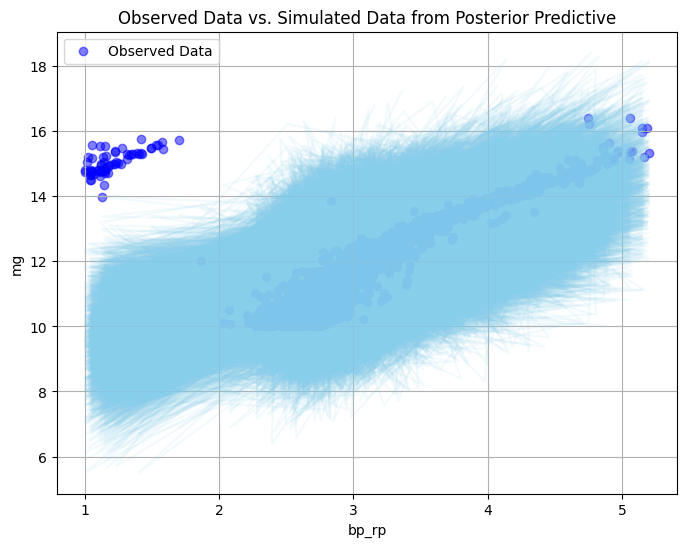

In [185]:
# Visualize observed and simulated data
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, color='blue', label='Observed Data', alpha=0.5)
for i in range(simulated_data.shape[0]):
    plt.plot(x_data, simulated_data[i], color='skyblue', alpha=0.1)  
plt.xlabel('bp_rp')
plt.ylabel('mg')
plt.title('Observed Data vs. Simulated Data from Posterior Predictive')
plt.legend()
plt.grid()
plt.show()

Q3: simulated data is overloaded. They are considering the right format but couldnot track other data points thats outside the best fit line.